In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt

In [2]:
df = pd.read_csv('all_reviews.csv')

In [3]:
print("Number of Users:",len(set(df['User'])))
#clt.Counter(df['User'])

Number of Users: 9318


In [4]:
posScore = df['Score'].quantile(.5)
#posScore = 75

In [5]:
np.mean(df['Score'])

77.22090459575743

In [6]:
print(df.columns)
print("50th Percentile at",posScore)

Index(['Year', 'Date', 'User', 'Release', 'Score', 'Band'], dtype='object')
50th Percentile at 83.0


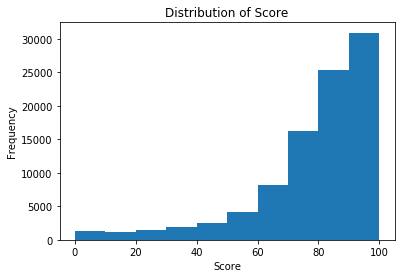

In [7]:
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(df['Score'])
plt.savefig("Distribution of Score.png")

In [8]:
mp = {} #mp[release] = list(reviews)
for i in range(len(df)):
    if df['Score'][i] >= posScore:#positive review is defined as score >= 75
    #if df['Score'][i] == 100:#only consider positive review as full score of 100
        if df['Release'][i] not in mp:
            mp[df['Release'][i]] = []
        mp[df['Release'][i]].append((df['User'][i],float(df['Score'][i])))

In [9]:
G = nx.Graph() #network of users
B = nx.Graph() #bipartite graph between users and releases

In [10]:
#construction of bipartite graph between users and releases
users = set()
for release in mp:
    for item in mp[release]:
        B.add_edge(release,str(item[0])+'U')#to differentiate items in bipartite graph
        users.add(str(item[0])+'U')

In [11]:
#constructing edges, and counting the frequency (i.e. number of repeated edges)
edges = {}
for user in users:
    for release in B.adj[user]:
        for node in B.adj[release]:
            if node != user:
                if (user, node) in edges:
                    edges[(user, node)] += 1
                elif (node, user) in edges:
                    edges[(node, user)] += 1
                else:
                    edges[(user, node)] = 1

In [12]:
for edge in edges:
    G.add_edge(edge[0], edge[1], weight = edges[edge])

In [13]:
print("Number of Releases Used =",len(mp))

Number of Releases Used = 23883


In [14]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
for u,v in G.edges():
    #similarity = 2*overlap/sum of degrees of u and v
    G[u][v]['similarity'] = (2*G[u][v]['weight'])/(G.degree(u,weight = 'weight')+G.degree(v,weight = 'weight')) 

In [15]:
#Assigning weights based on frequency
weights = [G[u][v]['weight'] for u,v in G.edges()]
sim_score = [G[u][v]['similarity'] for u,v in G.edges()]
#print(weights)

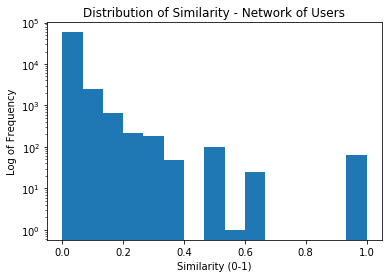

In [16]:
plt.title('Distribution of Similarity - Network of Users')
plt.xlabel('Similarity (0-1)')
plt.ylabel('Log of Frequency')
#print(min(sim_score))
plt.hist(sim_score, log = True, bins = 15)#specify the number of bins -> 
plt.savefig("Distribution of Similarity - Network of Users.png")

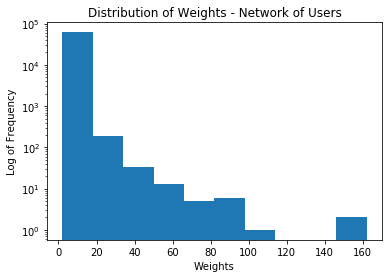

In [17]:
plt.title('Distribution of Weights - Network of Users')
plt.xlabel('Weights')
plt.ylabel('Log of Frequency')
plt.hist(weights, log = True)
plt.savefig("Distribution of Weights - Network of Users.png")

In [18]:
print("Maximum Weight (i.e. Frequency) =",max(weights))
print("Number of edges =",len(weights))
print("Number of nodes =",len(G.nodes()))

Maximum Weight (i.e. Frequency) = 162
Number of edges = 62023
Number of nodes = 6176


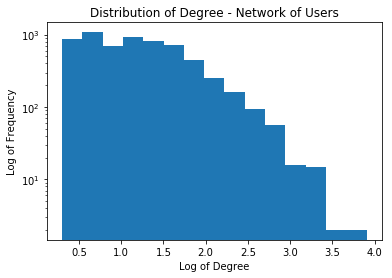

In [19]:
plt.title('Distribution of Degree - Network of Users')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
data = np.log10([b for a,b in G.degree(list(G.nodes()), weight = 'weight')])
#_,bins = np.histogram(data + 1, bins='auto')
#data = [b for a,b in G.degree(list(G.nodes()))]
#plt.gca().set_xscale('log')
plt.hist(data, log = True, bins = 15)
plt.savefig("Distribution of Degree - Network of Users.png")
#print([b for a,b in G.degree(list(G.nodes()))])
#Hopefully able to observe Power Law Distribution

In [20]:
#Only run this when size is small
#nx.draw(G, node_size = 10, width = weights)
#plt.show()

In [21]:
clt.Counter(sorted([len(cc) for cc in nx.connected_components(G)]))

Counter({2: 64, 3: 8, 4: 1, 5: 1, 6015: 1})

In [22]:
#Splitting the graph into connected subgraphs
'''
graphs = list(nx.connected_components(G))

for subgraph in graphs:
    if len(subgraph) < 3:#only consider subgraphs with size > 3
        continue
    graph = G.subgraph(subgraph)
    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]
    nx.draw(graph, node_size = 10, width = weights1)
    plt.show()
'''

"\ngraphs = list(nx.connected_components(G))\n\nfor subgraph in graphs:\n    if len(subgraph) < 3:#only consider subgraphs with size > 3\n        continue\n    graph = G.subgraph(subgraph)\n    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]\n    nx.draw(graph, node_size = 10, width = weights1)\n    plt.show()\n"

In [23]:
H = nx.Graph() #network of releases

In [24]:
#constructing edges, and counting the frequency (i.e. number of repeated edges)
edgesNew = {}
for release in mp:
    for item in B.adj[release]:
        for node in B.adj[item]:
            if node != release:
                if (release, node) in edgesNew:
                    edgesNew[(release, node)] += 1
                elif (node, release) in edgesNew:
                    edgesNew[(node, release)] += 1
                else:
                    edgesNew[(release, node)] = 1

for edge in edgesNew:
    H.add_edge(edge[0], edge[1], weight = edgesNew[edge])

#Assigning weights based on frequency
weightsNew = [H[u][v]['weight'] for u,v in H.edges()]

In [25]:
len(edgesNew)

2645164

In [26]:
print("Number of Nodes =",len(H.nodes()))
print("Number of Edges =",len(H.edges()))
print("Maximum Weight =",max(weightsNew))
print("Minimum Weight =",min(weightsNew))

Number of Nodes = 22375
Number of Edges = 2645164
Maximum Weight = 22
Minimum Weight = 2


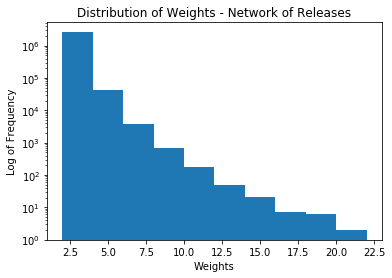

In [27]:
plt.title('Distribution of Weights - Network of Releases')
plt.xlabel('Weights')
plt.ylabel('Log of Frequency')
plt.hist(weightsNew, log = True)
plt.savefig("Distribution of Weights - Network of Releases.png")

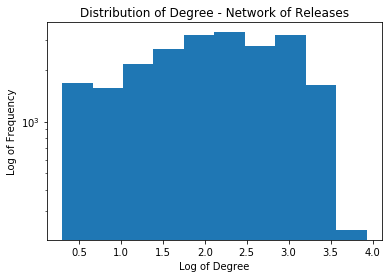

In [28]:
plt.title('Distribution of Degree - Network of Releases')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.hist(np.log10([b for a,b in H.degree(list(H.nodes()),weight = 'weight')]), log = True)
plt.savefig("Distribution of Degree - Network of Releases.png")
#print([H for a,b in H.degree(list(H.nodes()))])
#Hopefully able to observe Power Law Distribution

In [29]:
#Only run this when size is small
#nx.draw(H, node_size = 10, width = weightsNew)
#plt.show()

In [30]:
GC = G.subgraph(list(nx.connected_components(G))[0])#giant component of network of users

In [31]:
len(GC.nodes())

6015

In [32]:
powers = []
for node in GC.nodes():
    powers.append(1.1**math.floor(math.log(GC.degree(node,weight = 'weight'),1.1)))

(array([5.976e+03, 2.400e+01, 1.100e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.94871710e+00, 7.79633486e+02, 1.55731825e+03, 2.33500302e+03,
        3.11268779e+03, 3.89037256e+03, 4.66805733e+03, 5.44574210e+03,
        6.22342687e+03, 7.00111164e+03, 7.77879641e+03]),
 <a list of 10 Patch objects>)

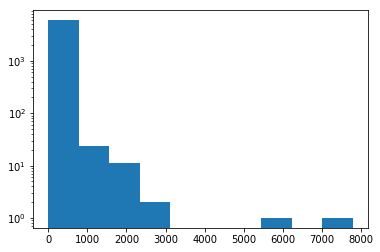

In [33]:
plt.hist(powers, log = True)

In [34]:
degree_x = []
degree_y = []
d_freq = clt.Counter(powers)
for item in d_freq:
    degree_x.append(math.log10(math.sqrt(item*(item*1.1))))
    degree_y.append(math.log10(d_freq[item]))

In [35]:
m,c = np.polyfit(degree_x,degree_y,1)#polynomial degree 1 (i.e. linear)

In [36]:
print(m,c)

-0.9300357566248476 3.5073667329518963


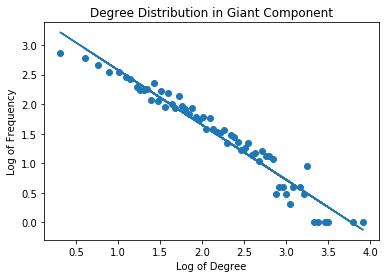

In [37]:
plt.title('Degree Distribution in Giant Component')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.scatter(degree_x,degree_y)
plt.plot(degree_x,m*np.array(degree_x)+c)
plt.savefig('Degree Distribution in Giant Component')

In [38]:
y_pred = [m*x + c for x in degree_x]
MSE = np.square(np.subtract(degree_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.030473808830360345


In [39]:
def cluster(sim):
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            GC_split[u][v]['weight'] = GC[u][v]['weight']
            GC_split[u][v]['similarity'] = GC[u][v]['similarity']
    return GC_split

In [40]:
def components(Graph):
    return list(nx.connected_components(Graph))

In [41]:
def getSize(Graph):
    return [len(x) for x in list(nx.connected_components(Graph))]

In [42]:
def entropy(sim):
    sum = 0
    clusters = components(cluster(sim))
    N = len(GC.nodes())
    for comp in clusters:
        P = len(comp)/N
        sum += -1*P*math.log10(P)
    return sum

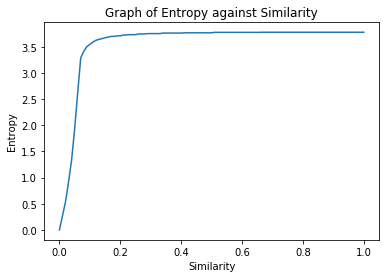

In [43]:
sim_x = 0.01*np.array(range(0,101)) #higher runtime, but smoother curve
#sim_x = 0.04*np.array(range(0,26))
plt.title('Graph of Entropy against Similarity')
plt.xlabel('Similarity')
plt.ylabel('Entropy')
plt.plot(sim_x,[entropy(x) for x in sim_x])
plt.savefig('Graph of Entropy against Similarity')

In [44]:
def certainty(sim):
    freq = clt.Counter(getSize(cluster(sim)))
    sum = 0
    N = len(GC.nodes())
    for item in freq:
        P = item*freq[item]/N
        sum += -1*P*math.log10(P)
    return sum

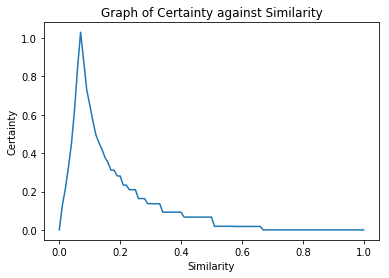

In [45]:
sim_x = 0.01*np.array(range(0,101)) #higher runtime, but smoother curve
#cert_x = 0.04*np.array(range(0,26))
plt.title('Graph of Certainty against Similarity')
plt.xlabel('Similarity')
plt.ylabel('Certainty')
plt.plot(sim_x,[certainty(x) for x in sim_x])
plt.savefig('Graph of certainty against Similarity')

In [46]:
#Based on graph, calculate similarity that gives maximum certainty
'''for x in sim_x[:20]:
    print(x,certainty(x))'''
#maximum
#0.07,1.0302546261242758
'''for x in range(60,80):
    print(x/1e3,certainty(x/1e3))'''
#maximum
#0.067 1.061786419877182
#0.068 1.0614383510267185
'''for x in range(660,680):
    print(x/1e4,certainty(x/1e4))'''
#maximum
#0.0674 1.061786419877182
'''for x in range(6730,6750):
    print(x/1e5,certainty(x/1e5))'''
#maximum
#0.06741 1.061786419877182
#Therefore, optimal similarity value is determined to be 0.067
optsim = 0.067 #this value is determined for when posScore = 75
print(optsim,certainty(optsim))

0.067 1.0617864198771818


In [47]:
DG = cluster(optsim)#disjointed graph (i.e. after removing edges with similarity below threshold similarity of optsim = 0.67)
comp = components(DG)

In [48]:
#clt.Counter(len(x) for x in comp)

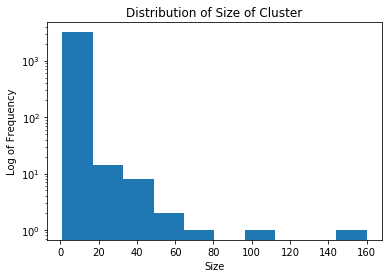

In [49]:
plt.title('Distribution of Size of Cluster')
plt.xlabel('Size')
plt.ylabel('Log of Frequency')
plt.hist([len(x) for x in comp], log = True)
plt.savefig('Distribution of Size of Cluster')